In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy import stats
from scipy.interpolate import interp1d

sys.path.insert(1, '../')
#import reservoir and system code
from reservoir import *
from system import *

In [2]:
sigma = 10   # Prandlt number
rho = 28     # Rayleigh number
beta = 8.0/3

D = 3

#lorenz63 model
def lorenz(n, t, p):
    sigma, rho, beta = p
    x, y, z = n
    dxdt = sigma*(y-x)
    dydt = x*(rho-z)-y
    dzdt = x*y - beta*z
    dXdt = [dxdt, dydt, dzdt]
    return dXdt

def jac(X, t, p):
    sigma, rho, beta = p
    x, y, z = X
    return np.array([[-sigma, sigma, 0],
                     [-z+rho, -1, -x],
                     [y, x, -beta]])

# build the system from the dynamical equations
# jacobian is not necessary if you do not care about the lyapunov exp
lor63sys = system(lorenz, (sigma, rho, beta), D, 0.001, fjac = jac)

In [3]:
t, u = lor63sys.integrate(-20, 200)

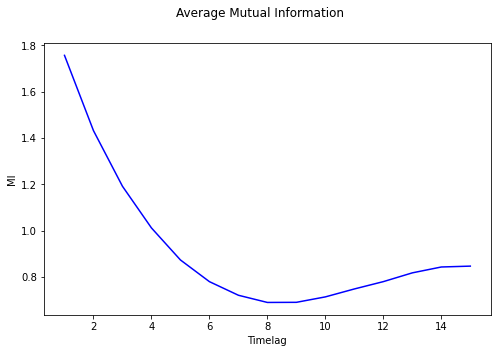

Enter a number up to search for first minimum
end search: 10
The first min of MI is: T=8


8

In [4]:
lor63sys.findMinAMI(0.3, sample = 20)

In [5]:
lor63sys.FNN(5)

[99.7  5.   0.   0.   0. ]
minimum embedding dimension is 3 with NFNN 0.000


In [57]:
class data:
    def __init__(self, time, data):
        self.U = interp1d(time, data)
        if data.ndim == 1:
            self.D = 1
        else:
            self.D, _ = data.shape
    def getU(self): return self.U
    
    def integrate(self, spinup_time, time, noise = 0): pass
    
    def globalLyap(self, time, dt, x0):
        lyap = [0.923, 0.042, -14.668]*np.ones((int(time/dt), self.D))
        self.LE = lyap
        return lyap

In [58]:
datax = data(lor63sys.t, lor63sys.u[:, 0].reshape(1, -1))

In [59]:
datax.D

1

In [60]:
datax.getU()(1)

array([-2.87897996])

In [61]:
t_td, y_td = lor63sys.get_td_coords()

data_td = data(t_td, y_td)

In [62]:
data_td.getU()(1)

array([ 7.31253875, -2.87897996, -6.72771977])

# Try Just with X

In [63]:
N = 500
sigma = 0.014 #scaling of the input

# dr/dt = gamma * (-r + tanh(M*r+Win*u))
params = {'name': 'Lor63',
          'N': N, #number of neurons
          'D': 1, #dimension of the input system
          'gamma': 10, #time constant for the system
          'M_a': -1, #M connectivity matrix lower bound
          'M_b': 1, #M connectivity matrix upper bound
          'M_pnz': 0.02, #M connectivity matrix sparsity
          'M_SR': 0.9, #M connectivity matrix spectral radius
          'Win_a': -sigma, #Win input matrix lower bound
          'Win_b': sigma, #Win input matrix upper bound
          'time_step': 0.001, #integration time step for reservoir
          'spinup_time': 10, #time it takes to synchronize res with sys
          'system': datax, #system to run reservoir over
          'saveplots': False} #save the plots


#build the reservoir
lor63Res = reservoir(params)

In [64]:
%%time
train_time = 60 #time for training

#time between training points (must be a multiple of the res time step)
train_time_step = 0.02

#regularization term
beta = 1e-6

data = lor63Res.train(train_time, #time to train the reservoir
                      train_time_step, #time step over which to train (> integration time step)
                      None,
                      beta)

CPU times: user 1.6 s, sys: 19.1 ms, total: 1.62 s
Wall time: 1.3 s


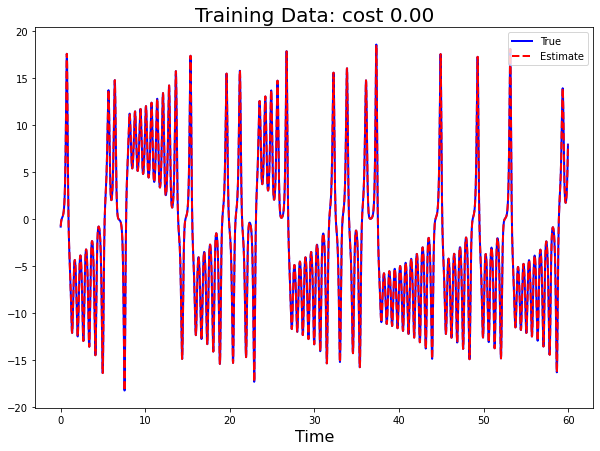

In [65]:
lor63Res.plotTraining()

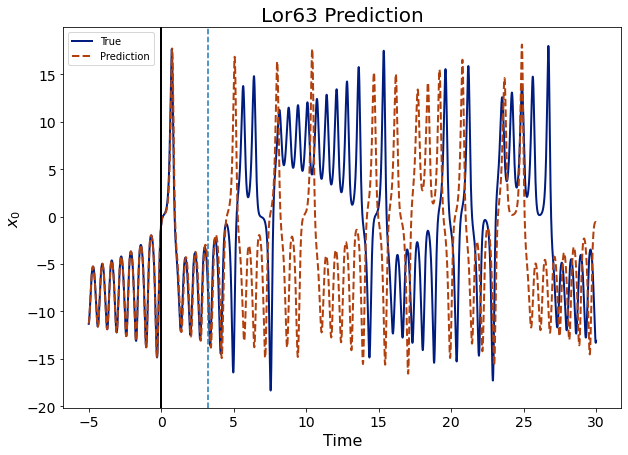

In [66]:
pred_acc, u_pred, u_true, pred= lor63Res.predict(30, acc = 1, show = True, retDat = True)

In [67]:
lor63Res.setDQ(None)

In [76]:
lor63Res.globalLyap_TLM(150, 0.1, num_save = 3, savetxt = False)

(array([  0.923,   0.042, -14.668]),
 array([ 0.7382257 ,  0.26483256, -0.96988636], dtype=float32))

In [ ]:
plt.plot(lor63Res.LE[:, 0])
plt.plot(lor63Res.LE[:, 1])
plt.plot(lor63Res.LE[:, 2])
plt.ylim(-1, 1)

# Now with Time Delay Coordinates

In [86]:
N = 2000
sigma = 0.014 #scaling of the input

# dr/dt = gamma * (-r + tanh(M*r+Win*u))
params = {'name': 'Lor63',
          'N': N, #number of neurons
          'D': 3, #dimension of the input system
          'gamma': 10, #time constant for the system
          'M_a': -1, #M connectivity matrix lower bound
          'M_b': 1, #M connectivity matrix upper bound
          'M_pnz': 0.02, #M connectivity matrix sparsity
          'M_SR': 0.9, #M connectivity matrix spectral radius
          'Win_a': -sigma, #Win input matrix lower bound
          'Win_b': sigma, #Win input matrix upper bound
          'time_step': 0.001, #integration time step for reservoir
          'spinup_time': 10, #time it takes to synchronize res with sys
          'system': data_td, #system to run reservoir over
          'saveplots': False} #save the plots


#build the reservoir
lor63Res = reservoir(params)

In [87]:
train_time = 60 #time for training

#time between training points (must be a multiple of the res time step)
train_time_step = 0.02

#regularization term
beta = 1e-5

data = lor63Res.train(train_time, #time to train the reservoir
                      train_time_step, #time step over which to train (> integration time step)
                      None,
                      beta)

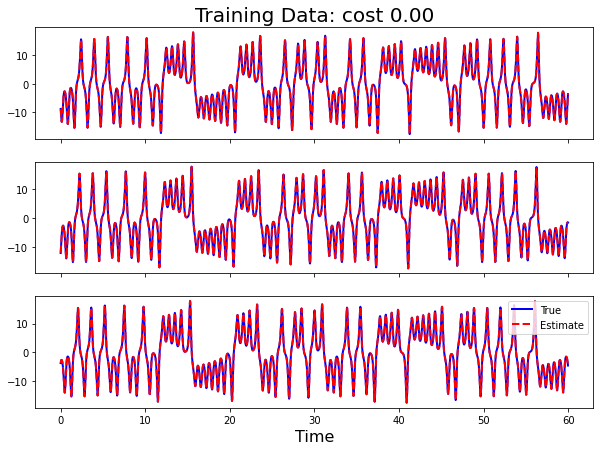

In [88]:
lor63Res.plotTraining()

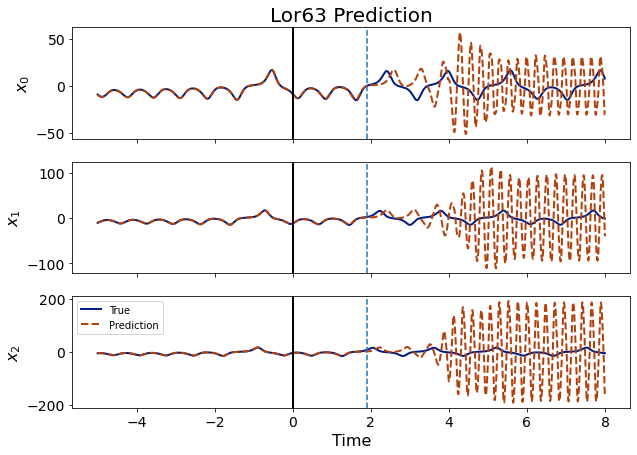

In [89]:
pred_acc, u_pred, u_true, pred= lor63Res.predict(8, acc = 1, show = True, retDat = True)